In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available! You can use GPU acceleration.")
else:
    print("CUDA is not available. Using CPU instead.")

CUDA is available! You can use GPU acceleration.


In [2]:
#!pip install transformers
#!pip install matplotlib
#!pip install pandas 

# FUSED MLP kernel with RMSnorm

# Isolate the MLP
mlp = decoder_layer.mlp
torch.onnx.export(
    mlp,
    (mlp_input,),
    "mlp.onnx",
)

The `mlp` module actually correspond to a gated multi-layer perceptron.  
See https://arxiv.org/pdf/2002.05202 as a reference (we later call the Swish function SiLU). 
The gated linear unit returns:  
`self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))`, that is to say:
$$(\sigma(X \times G^T) \odot (X \times U^T)) \times D^T$$
With the shapes:
- $X: n,d$
- $U: \tilde{d},d$
- $G: \tilde{d},d$
- $D: d,\tilde{d}$  

$\sigma$ corresponds to the $SiLU$ activation function: $\sigma(x)=x*sigmoid(x)$

![MLP netron labeled](mlp_netron_labeled.png)

# Triton kernel
https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/  
https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html

I start by exploring my GPU characteristics, using CUDA demo suite `deviceQuery` (`Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1\extras\demo_suite`):
```
Device 0: "NVIDIA GeForce GTX 950M"
  CUDA Driver Version / Runtime Version          12.1 / 12.1
  CUDA Capability Major/Minor version number:    5.0
  Total amount of global memory:                 2048 MBytes (2147352576 bytes)
  ( 5) Multiprocessors, (128) CUDA Cores/MP:     640 CUDA Cores
  GPU Max Clock rate:                            1124 MHz (1.12 GHz)
  Memory Clock rate:                             1001 Mhz
  Memory Bus Width:                              128-bit
  L2 Cache Size:                                 2097152 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(65536), 2D=(65536, 65536), 3D=(4096, 4096, 4096)
  Maximum Layered 1D Texture Size, (num) layers  1D=(16384), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(16384, 16384), 2048 layers
  Total amount of constant memory:               zu bytes
  Total amount of shared memory per block:       zu bytes
  Total number of registers available per block: 65536
  Warp size:                                     32
  Maximum number of threads per multiprocessor:  2048
  Maximum number of threads per block:           1024
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)
  Maximum memory pitch:                          zu bytes
  Texture alignment:                             zu bytes
  Concurrent copy and kernel execution:          Yes with 4 copy engine(s)
  Run time limit on kernels:                     Yes
  Integrated GPU sharing Host Memory:            No
  Support host page-locked memory mapping:       Yes
  Alignment requirement for Surfaces:            Yes
  Device has ECC support:                        Disabled
  CUDA Device Driver Mode (TCC or WDDM):         WDDM (Windows Display Driver Model)
  Device supports Unified Addressing (UVA):      Yes
  Device supports Compute Preemption:            No
  Supports Cooperative Kernel Launch:            No
  Supports MultiDevice Co-op Kernel Launch:      No
  Device PCI Domain ID / Bus ID / location ID:   0 / 1 / 0
  Compute Mode:
     < Default (multiple host threads can use ::cudaSetDevice() with device simultaneously) >
```

I need to compute:
$$
\begin{cases}
    Z =  & X \times G^T\\
    \tilde{Z} = & Z \odot sigmoid(Z) \odot (X\times U^T)\\
    ... = & \tilde{Z} \times D^T
  \end{cases}$$

I propose the following parallelization scheme:
- Compute $Z$ and $X \times U^T$ in parallel
- Compute $sigmoid(Z)$
- Compute the triple element wise multiplication for $\tilde{Z}$
- Compute $\tilde{Z} \times D^T$  

The first step is natively implemented when using
$X \times ( 
    \begin{array}{c}
    G^T \\
    U^T \\
    \end{array}
    )$
and masks to retrieve results.
The novelty is step 3, that is to say a kernel for triple elementwise matrix multiplication.
Performance improvements from other steps will not come from parallelization but from cach usage optimization.

With a naive implementation, I get the following performance:  
![Naive triton kernel](naive_triton_kernel.png)

# triton retry

tensor([[7.5458e-03, 3.1605e-01, 1.0115e-02,  ..., 6.2261e-01, 1.0132e-02,
         4.6430e-03],
        [2.0902e-01, 2.1055e-02, 1.5783e-02,  ..., 1.7118e-01, 2.6471e-02,
         5.4862e-01],
        [2.2141e-01, 2.4142e-01, 4.1235e-02,  ..., 5.0186e-02, 9.3337e-04,
         1.7273e-01],
        ...,
        [3.9977e-03, 3.8225e-02, 4.3452e-01,  ..., 4.9965e-02, 9.3043e-02,
         5.0408e-02],
        [6.3219e-03, 1.4419e-01, 1.1127e-01,  ..., 2.7275e-01, 5.5073e-02,
         2.2844e-01],
        [4.4574e-01, 1.1102e-02, 3.6639e-04,  ..., 4.0252e-02, 1.9692e-01,
         6.1964e-02]], device='cuda:0')
tensor([[7.5458e-03, 3.1605e-01, 1.0115e-02,  ..., 6.2261e-01, 1.0132e-02,
         4.6430e-03],
        [2.0902e-01, 2.1055e-02, 1.5783e-02,  ..., 1.7118e-01, 2.6471e-02,
         5.4862e-01],
        [2.2141e-01, 2.4142e-01, 4.1235e-02,  ..., 5.0186e-02, 9.3337e-04,
         1.7273e-01],
        ...,
        [3.9977e-03, 3.8225e-02, 4.3452e-01,  ..., 4.9965e-02, 9.3043e-02,
        

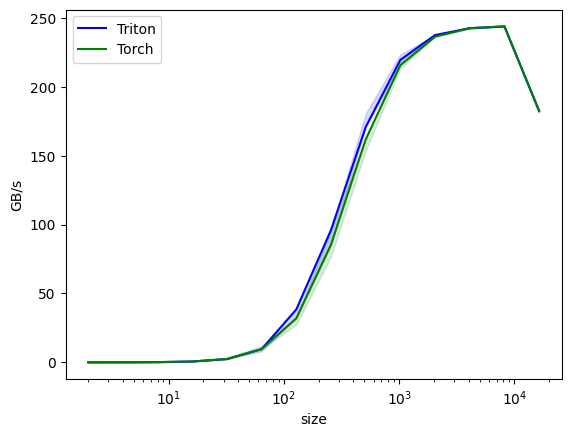

vector-add-performance:
       size      Triton       Torch
0       2.0    0.011719    0.011719
1       4.0    0.037500    0.041667
2       8.0    0.150000    0.150000
3      16.0    0.600000    0.600000
4      32.0    2.400000    2.400000
5      64.0    9.600000    9.600000
6     128.0   38.400001   31.999999
7     256.0   96.000000   85.333330
8     512.0  170.666661  161.684218
9    1024.0  219.428568  215.578943
10   2048.0  237.449270  236.307695
11   4096.0  242.426632  242.426632
12   8192.0  243.703758  243.741515
13  16384.0  182.445661  182.255387


In [1]:
import torch
import triton
import triton.language as tl
import itertools


@torch.jit.script
def naive_triple_mul(A, B, C):
    return A * B * C


def get_autotune_config():
    return [
        triton.Config({"BLOCK_SIZE": 2**i}, num_stages=j, num_warps=k) 
        for i, j, k in itertools.product([7, 8, 9, 10], [3, 4, 5], [2, 4, 8])
    ]

@triton.autotune(
    configs=get_autotune_config(),
    key=["n_elements"]
)
@triton.jit
def triple_mul_kernel(A_ptr, B_ptr, C_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    A = tl.load(A_ptr + offsets, mask=mask)
    B = tl.load(B_ptr + offsets, mask=mask)
    C = tl.load(C_ptr + offsets, mask=mask)
    output = A * B * C
    tl.store(output_ptr + offsets, output, mask=mask)

def triple_mul(A, B, C):
    output = torch.empty_like(A)
    assert A.is_cuda and B.is_cuda and C.is_cuda and output.is_cuda
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    triple_mul_kernel[grid](A, B, C, output, n_elements)
    return output

torch.manual_seed(0)
size = 314
A = torch.rand((size, size), device='cuda')
B = torch.rand((size, size), device='cuda')
C = torch.rand((size, size), device='cuda')
output_torch = A * B * C
output_triton = triple_mul(A, B, C)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}')

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(1, 15, 1)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
    ))
def benchmark(size, provider):
    A = torch.rand((size, size), device='cuda')
    B = torch.rand((size, size), device='cuda')
    C = torch.rand((size, size), device='cuda')
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_triple_mul(A, B, C), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triple_mul(A, B, C), quantiles=quantiles)
    gbps = lambda ms: 12 * size**2 / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)


# GLU tested

tensor([[ 893913.2500,  890179.6250,  950809.1875,  ...,  931846.8750,
          910658.1250,  867792.2500],
        [ 811969.0000,  809473.9375,  863437.1250,  ...,  846117.6875,
          827278.0000,  788966.7500],
        [1004337.0000, 1000290.5000, 1068331.7500,  ..., 1045453.7500,
         1024303.5000,  974487.7500],
        ...,
        [ 936454.3125,  934146.2500,  998653.8125,  ...,  978846.7500,
          956715.0000,  909345.3125],
        [1007237.5000, 1004716.7500, 1074972.1250,  ..., 1051827.0000,
         1027691.2500,  977795.4375],
        [1021163.7500, 1018157.0000, 1087734.2500,  ..., 1065002.0000,
         1041590.5000,  994895.7500]], device='cuda:0')
tensor([[1.5316e-02, 8.3652e-05, 1.3814e-01,  ..., 7.2535e-03, 2.9977e-02,
         2.8862e-03],
        [2.2118e-03, 6.8763e-03, 4.4843e-02,  ..., 4.2926e-03, 1.8591e-02,
         1.9150e-04],
        [5.0731e-04, 8.6001e-04, 1.9406e-01,  ..., 5.3947e-02, 7.4806e-03,
         3.0133e-03],
        ...,
        [1.

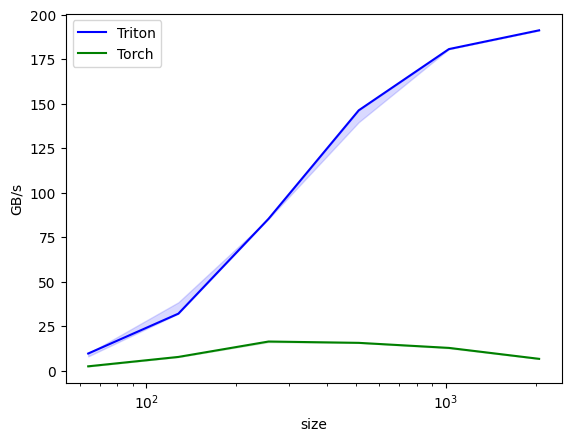

glu-performance:
     size      Triton      Torch
0    64.0    9.600000   2.400000
1   128.0   31.999999   7.680000
2   256.0   85.333330  16.340425
3   512.0  146.285715  15.593909
4  1024.0  180.705879  12.753503
5  2048.0  191.252913   6.606896


In [1]:
import torch
import triton
import triton.language as tl
import itertools

# Naive GLU function
@torch.jit.script
def naive_glu(X, G, U, D):
    Z = X @ G.T
    return (Z * torch.sigmoid(Z) * (X @ U.T)) @ D.T

# Autotune configuration
def get_autotune_config():
    return [
        triton.Config({"BLOCK_SIZE": 2**i}, num_stages=j, num_warps=k) 
        for i, j, k in itertools.product([7, 8, 9, 10], [3, 4, 5], [2, 4, 8])
    ]

# GLU kernel
@triton.autotune(
    configs=get_autotune_config(),
    key=["n_elements"]
)
@triton.jit
def glu_kernel(X_ptr, G_ptr, U_ptr, D_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    # Load matrices
    X = tl.load(X_ptr + offsets, mask=mask)
    G = tl.load(G_ptr + offsets, mask=mask)
    U = tl.load(U_ptr + offsets, mask=mask)
    D = tl.load(D_ptr + offsets, mask=mask)

    # Perform GLU operation
    Z = X * G
    sigmoid_Z = 1 / (1 + tl.exp(-Z))
    result = Z * sigmoid_Z * (X * U) * D

    # Store result
    tl.store(output_ptr + offsets, result, mask=mask)

# GLU wrapper
def glu(X, G, U, D):
    output = torch.empty_like(X, device='cuda')
    assert X.is_cuda and G.is_cuda and U.is_cuda and D.is_cuda and output.is_cuda
    n_elements = X.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    glu_kernel[grid](X, G, U, D, output, n_elements)
    return output

# Correctness check for GLU
size = 314
X = torch.rand((size, size), device='cuda')
G = torch.rand((size, size), device='cuda')
U = torch.rand((size, size), device='cuda')
D = torch.rand((size, size), device='cuda')
output_torch_glu = naive_glu(X, G, U, D)
output_triton_glu = glu(X, G, U, D)
print(output_torch_glu)
print(output_triton_glu)
print(f'The maximum difference between torch and triton for GLU is {torch.max(torch.abs(output_torch_glu - output_triton_glu))}')

# Benchmarking GLU
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(6, 12, 1)],  # Adjusting the size range for benchmarking
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='glu-performance',
        args={},
    ))
def benchmark_glu(size, provider):
    X = torch.rand((size, size), device='cuda')
    G = torch.rand((size, size), device='cuda')
    U = torch.rand((size, size), device='cuda')
    D = torch.rand((size, size), device='cuda')
    torch.cuda.empty_cache()  # Freeing GPU memory before benchmarking
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_glu(X, G, U, D), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: glu(X, G, U, D), quantiles=quantiles)
    gbps = lambda ms: 12 * size**2 / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark_glu.run(print_data=True, show_plots=True)

error in coding function

In [7]:
import torch
import triton
import triton.language as tl
import itertools

# Naive GLU function
@torch.jit.script
def naive_glu(X, G, U, D):
    Z = X @ G.T
    return (Z * torch.sigmoid(Z) * (X @ U.T)) @ D.T

# Autotune configuration
def get_autotune_config():
    return [
        triton.Config({"BLOCK_SIZE_M": 2**i, "BLOCK_SIZE_N": 2**i, "BLOCK_SIZE_K": 32}, num_stages=j, num_warps=k) 
        for i, j, k in itertools.product([7, 8, 9, 10], [3, 4, 5], [2, 4, 8])
    ]

# GLU kernel
@triton.autotune(
    configs=get_autotune_config(),
    key=["M", "N", "K"]
)
@triton.jit
def glu_kernel(X_ptr, G_ptr, U_ptr, D_ptr, output_ptr, M, N, K, stride_xm, stride_xk, stride_gn, stride_gk, stride_um, stride_uk, stride_dm, stride_dn, stride_out_m, stride_out_n, BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr):
    pid_m = tl.program_id(0)
    pid_n = tl.program_id(1)

    offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)

    mask_m = offs_m[:, None] < M
    mask_n = offs_n[None, :] < N
    mask_k = offs_k[:, None] < K

    Z_acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    XU_acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for k in range(0, K, BLOCK_SIZE_K):
        k_mask = (offs_k + k)[:, None] < K
        x_ptrs = X_ptr + offs_m[:, None] * stride_xm + (offs_k + k)[None, :] * stride_xk
        g_ptrs = G_ptr + offs_n[None, :] * stride_gn + (offs_k + k)[:, None] * stride_gk  # Transposing when loading
        u_ptrs = U_ptr + offs_m[:, None] * stride_um + (offs_k + k)[None, :] * stride_uk

        x = tl.load(x_ptrs, mask=mask_m & k_mask.T, other=0.0)
        g = tl.load(g_ptrs, mask=k_mask & mask_n, other=0.0)
        u = tl.load(u_ptrs, mask=mask_m & k_mask.T, other=0.0)

        Z_acc += tl.dot(x, g)
        XU_acc += tl.dot(x, u)

    sigmoid_Z = 1 / (1 + tl.exp(-Z_acc))
    result = Z_acc * sigmoid_Z * XU_acc

    d_ptrs = D_ptr + offs_n[None, :] * stride_dn + offs_m[:, None] * stride_dm
    d = tl.load(d_ptrs, mask=mask_n & mask_m.T, other=0.0)

    result = tl.dot(result, d)

    out_ptrs = output_ptr + offs_m[:, None] * stride_out_m + offs_n[None, :] * stride_out_n
    tl.store(out_ptrs, result, mask=mask_m & mask_n)

# GLU wrapper
def glu(X, G, U, D):
    assert X.is_cuda and G.is_cuda and U.is_cuda and D.is_cuda
    M, K = X.shape
    N = G.shape[0]
    output = torch.empty((M, N), device='cuda')
    grid = lambda meta: (triton.cdiv(M, meta['BLOCK_SIZE_M']), triton.cdiv(N, meta['BLOCK_SIZE_N']))
    glu_kernel[grid](X, G, U, D, output, M, N, K, X.stride(0), X.stride(1), G.stride(0), G.stride(1), U.stride(0), U.stride(1), D.stride(1), D.stride(0), output.stride(0), output.stride(1))
    return output

# Correctness check for GLU
size = 314
X = torch.rand((size, size), device='cuda')
G = torch.rand((size, size), device='cuda')
U = torch.rand((size, size), device='cuda')
D = torch.rand((size, size), device='cuda')
output_torch_glu = naive_glu(X, G, U, D)
output_triton_glu = glu(X, G, U, D)
print(output_torch_glu)
print(output_triton_glu)
print(f'The maximum difference between torch and triton for GLU is {torch.max(torch.abs(output_torch_glu - output_triton_glu))}')

# Benchmarking GLU
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(6, 12, 1)],  # Adjusting the size range for benchmarking
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='glu-performance',
        args={},
    ))
def benchmark_glu(size, provider):
    X = torch.rand((size, size), device='cuda')
    G = torch.rand((size, size), device='cuda')
    U = torch.rand((size, size), device='cuda')
    D = torch.rand((size, size), device='cuda')
    torch.cuda.empty_cache()  # Freeing GPU memory before benchmarking
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_glu(X, G, U, D), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: glu(X, G, U, D), quantiles=quantiles)
    gbps = lambda ms: 12 * size**2 / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark_glu.run(print_data=True, show_plots=True)


CompilationError: at 27:28:    for k in range(0, K, BLOCK_SIZE_K):
        k_mask = (offs_k + k)[:, None] < K
        x_ptrs = X_ptr + offs_m[:, None] * stride_xm + (offs_k + k)[None, :] * stride_xk
        g_ptrs = G_ptr + offs_n[None, :] * stride_gn + (offs_k + k)[:, None] * stride_gk  # Transposing when loading
        u_ptrs = U_ptr + offs_m[:, None] * stride_um + (offs_k + k)[None, :] * stride_uk

        x = tl.load(x_ptrs, mask=mask_m & k_mask.T, other=0.0)
        g = tl.load(g_ptrs, mask=k_mask & mask_n, other=0.0)
        u = tl.load(u_ptrs, mask=mask_m & k_mask.T, other=0.0)

        Z_acc += tl.dot(x, g)
        XU_acc += tl.dot(x, u)
                            ^
AssertionError('First input shape ([constexpr[128], constexpr[32]]) and second input shape [constexpr[128], constexpr[32]] are not compatible for matmul (second index of first shape (32) must be equal to first index of second shape (128)')